<a href="https://colab.research.google.com/github/TysonHeart/training_notebooks/blob/main/cc_stmt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install pdfplumber

In [32]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error


# LSTM with 4 units, 2 layers - LSTM and Dense
# Input is (samples x features)
def lstm1(df):

    print(type(df))

    # This converts pandas df to numpy array
    dataset = df["Amount"].values
    dataset = dataset.astype('float32')

    # print(df["Amount"])
    print("---")
    print(dataset.shape)
    print(type(dataset))
    dataset = dataset.reshape(-1, 1)

    # print("Original data")
    print(dataset.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # print("Fit transformed data:")
    # print(dataset)

    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size

    train = dataset[0:train_size,]
    test = dataset[train_size:len(dataset),]

    print(len(train), len(test))

    # train = train[0:5, :]
    # print(f"Shortened dataset shape: {train.shape}")

    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    print(f"trainX shape: {trainX.shape}, trainX type: {type(trainX)}")
    print(f"trainY shape: {trainY.shape}, trainY type: {type(trainY)}")

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    print(f"trainPredict shape: {trainPredict.shape}, trainPredict type: {type(trainPredict)}")

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    print(f"inverse_transform(trainPredict) shape: {trainPredict.shape}, inverse_transform(trainPredict) type: {type(trainPredict)}")

    trainY = scaler.inverse_transform([trainY])
    testY = scaler.inverse_transform([testY])

    print(f"trainY shape: {trainY.shape}, trainY type: {type(trainY)}")

    print(f"trainY: {trainY[0]}")
    print(f"trainPredict: {trainPredict[:,0]}")

    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))

    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))


    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()


# Added look_back number of inputs to generate one output.
def lstm2(df):

    print(type(df))

    # This converts pandas df to numpy array
    dataset = df["Amount"].values
    dataset = dataset.astype('float32')

    # print(df["Amount"])
    print("---")
    print(dataset.shape)
    print(type(dataset))
    dataset = dataset.reshape(-1, 1)

    # print("Original data")
    print(dataset.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # print("Fit transformed data:")
    # print(dataset)

    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size

    train = dataset[0:train_size,]
    test = dataset[train_size:len(dataset),]

    print(len(train), len(test))

    # train = train[0:5, :]
    # print(f"Shortened dataset shape: {train.shape}")

    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    print(f"trainX shape: {trainX.shape}, trainX type: {type(trainX)}")
    print(f"trainY shape: {trainY.shape}, trainY type: {type(trainY)}")


    epochs=20
    batch_size=1
    # create and fit the LSTM network
    model = Sequential()
    #model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(LSTM(4, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')


    for i in range(epochs):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.layers[0].reset_state()

    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
    print(f"trainPredict shape: {trainPredict.shape}, trainPredict type: {type(trainPredict)}")

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    print(f"inverse_transform(trainPredict) shape: {trainPredict.shape}, inverse_transform(trainPredict) type: {type(trainPredict)}")

    trainY = scaler.inverse_transform([trainY])
    testY = scaler.inverse_transform([testY])

    print(f"trainY shape: {trainY.shape}, trainY type: {type(trainY)}")

    print(f"trainY: {trainY[0]}")
    print(f"trainPredict: {trainPredict[:,0]}")

    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))

    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))


    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()


# Stacking of 2 LSTM layers. Add return_sequences=True to return
# hidden state from each sample
# hidden output is (batch_size, time_steps, units)
def lstm3(df):

    print(type(df))

    # This converts pandas df to numpy array
    dataset = df["Amount"].values
    dataset = dataset.astype('float32')

    # print(df["Amount"])
    print("---")
    print(dataset.shape)
    print(type(dataset))
    dataset = dataset.reshape(-1, 1)

    # print("Original data")
    print(dataset.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # print("Fit transformed data:")
    # print(dataset)

    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size

    train = dataset[0:train_size,]
    test = dataset[train_size:len(dataset),]

    print(len(train), len(test))

    # train = train[0:5, :]
    # print(f"Shortened dataset shape: {train.shape}")

    look_back = 1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    print(f"trainX shape: {trainX.shape}, trainX type: {type(trainX)}")
    print(f"trainY shape: {trainY.shape}, trainY type: {type(trainY)}")


    epochs=20
    batch_size=1
    # create and fit the LSTM network
    model = Sequential()
    #model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(LSTM(4, stateful=True, return_sequences=True))
    model.add(LSTM(4, stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')


    for i in range(epochs):
      model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
      model.layers[0].reset_state()

    trainPredict = model.predict(trainX, batch_size=batch_size)
    testPredict = model.predict(testX, batch_size=batch_size)
    print(f"trainPredict shape: {trainPredict.shape}, trainPredict type: {type(trainPredict)}")

    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    testPredict = scaler.inverse_transform(testPredict)
    print(f"inverse_transform(trainPredict) shape: {trainPredict.shape}, inverse_transform(trainPredict) type: {type(trainPredict)}")

    trainY = scaler.inverse_transform([trainY])
    testY = scaler.inverse_transform([testY])

    print(f"trainY shape: {trainY.shape}, trainY type: {type(trainY)}")

    print(f"trainY: {trainY[0]}")
    print(f"trainPredict: {trainPredict[:,0]}")

    trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))

    testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))


    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()



Successful connection with sqlite version 2.6.0
count is [504]


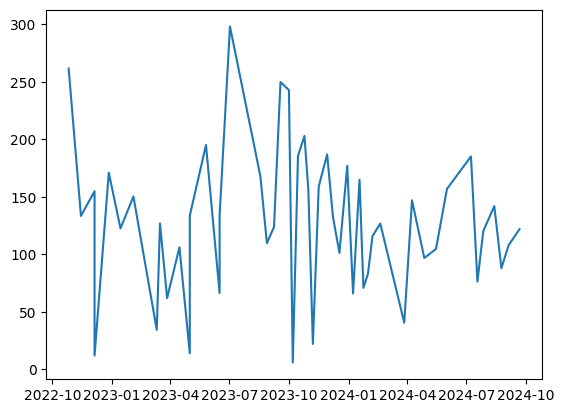

<class 'pandas.core.frame.DataFrame'>
---
(50,)
<class 'numpy.ndarray'>
(50, 1)
33 17
trainX shape: (31, 1, 1), trainX type: <class 'numpy.ndarray'>
trainY shape: (31,), trainY type: <class 'numpy.ndarray'>
31/31 - 7s - 231ms/step - loss: 0.3055
31/31 - 0s - 5ms/step - loss: 0.2001
31/31 - 0s - 8ms/step - loss: 0.1345
31/31 - 0s - 6ms/step - loss: 0.0829
31/31 - 0s - 6ms/step - loss: 0.0563
31/31 - 0s - 5ms/step - loss: 0.0565
31/31 - 0s - 4ms/step - loss: 0.0567
31/31 - 0s - 6ms/step - loss: 0.0563
31/31 - 0s - 4ms/step - loss: 0.0562
31/31 - 0s - 4ms/step - loss: 0.0563
31/31 - 0s - 7ms/step - loss: 0.0562
31/31 - 0s - 6ms/step - loss: 0.0562
31/31 - 0s - 8ms/step - loss: 0.0561
31/31 - 0s - 5ms/step - loss: 0.0561
31/31 - 0s - 6ms/step - loss: 0.0561
31/31 - 0s - 9ms/step - loss: 0.0560
31/31 - 0s - 12ms/step - loss: 0.0560
31/31 - 0s - 8ms/step - loss: 0.0560
31/31 - 0s - 7ms/step - loss: 0.0559
31/31 - 0s - 10ms/step - loss: 0.0559
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
15/15 ━━━━

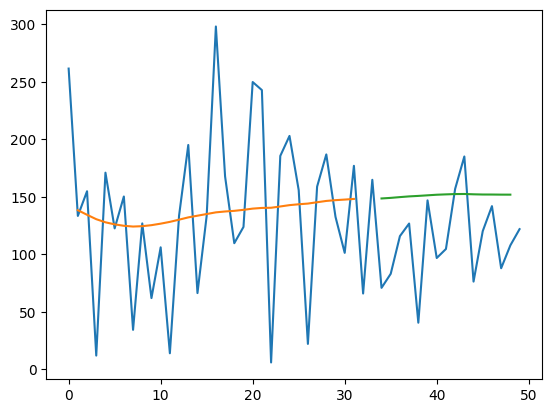

In [33]:
import os
import sqlite3
from sqlite3 import Error
import pandas as pd
import pdfplumber
import re
import matplotlib.pyplot as plt
from datetime import datetime
# from lstm1 import lstm1



def create_connection():
    conn = None
    try:
        conn = sqlite3.connect('/content/sample_data/cc_transactions.db')  # Create a connection to the SQLite database
        print(f"Successful connection with sqlite version {sqlite3.version}")
    except Error as e:
        print(e)

    return conn

def create_table(conn):
    try:
        query = """CREATE TABLE IF NOT EXISTS cc_transactions (
                    SaleDate text,
                    PostDate text,
                    Description text,
                    Amount real);"""

        cursor = conn.cursor()
        cursor.execute(query)
    except Error as e:
        print(e)

def insert_transaction(conn, transaction):
    try:
        query = """INSERT INTO cc_transactions (SaleDate, PostDate, Description, Amount) VALUES (?, ?, ?, ?);"""

        cursor = conn.cursor()
        cursor.execute(query, transaction)  # Replace the placeholders with actual values
        conn.commit()
    except Error as e:
        print(e)


def debug_table(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        print(f"Found {len(pdf.pages)} pages in PDF")
        main_page = pdf.pages[1]
        im = main_page.to_image(resolution=150)
        dim = im.debug_tablefinder({
                "vertical_strategy": "text",
                "horizontal_strategy": "text",
                "intersection_tolerance": 0,
                "min_words_horizontal": 10,
                "min_words_vertical": 3,
                "snap_tolerance": 2,
                "text_tolerance": 3,
                "edge_min_length": 1
        })
        dim.show()


def extract_billing_period(pdf_path):

    with pdfplumber.open(pdf_path) as pdf:
        # First get billing period
        period_found = False
        page = pdf.pages[0]

        text_lines = page.extract_text().split("\n")
        for line in text_lines:
            if line.startswith("Billing Period:"):
                print(f"billing period for file {pdf_path} : {line}")
                period_found = True
                pattern = r"Billing Period: (\d{2}/\d{2}/\d{2})-(\d{2}/\d{2}/\d{2})"
                match = re.search(pattern, line)
                if match:
                    start_date_str = match.group(1)
                    end_date_str = match.group(2)
                    start_date = datetime.strptime(start_date_str, "%m/%d/%y")
                    end_date = datetime.strptime(end_date_str, "%m/%d/%y")
                    return (start_date, end_date)

        if not period_found:
            print("ERROR: billing period not found")
            return None


def extract_transactions(pdf_path):
    transactions = []
    transaction_regex = r'^(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01])\s(0[1-9]|1[0-2])/(0[1-9]|[12]\d|3[01])\s([^$\n]+?)\s\$(\d+\.\d{2})'

    # Get billing period first to identify manage year of transaction since
    # we don't get year in transaction history
    resp = extract_billing_period(pdf_path)
    if resp is not None:
        (start_date, end_date) = resp
    else:
        print(f"ERROR: billing period not found in file {pdf_path}. Cannot extract transactions from this file")
        return None

    with pdfplumber.open(pdf_path) as pdf:
        print(f"Found {len(pdf.pages)} pages in PDF")

        main_page = pdf.pages[1]
        text_lines = main_page.extract_text().split("\n")

        marker_found = False

        sale_year, post_year = start_date.year, start_date.year
        prev_sale_month, prev_post_month = 0, 0

        # TODO - the logic where sale year and post year are different is not handled yet.
        # For eg: sale date = Dec 31 2023, post date = Jan 2 2024.

        for line in text_lines:
            if line.startswith("Standard Purchases"):
                marker_found = True

            if marker_found: # if marker found, go ahead and parse next few lines
                # print(f"Pre Match line: {line}")
                match = re.match(transaction_regex, line)
                if match:
                    # print(f"Match found: {line}")
                    sale_month, post_month = int(match.group(1)),int(match.group(3))

                    # For rollover from Dec->Jan
                    if sale_month < prev_sale_month:
                        sale_year = end_date.year
                    if post_month < prev_post_month:
                        post_year = end_date.year

                    transactions.append((
                        f"{sale_month}/{match.group(2)}/{sale_year}",
                        f"{post_month}/{match.group(4)}/{post_year}",
                        match.group(5),
                        match.group(6)
                    ))

                    prev_sale_month = sale_month
                    prev_post_month = post_month

    return transactions


def count_db_recs(conn):
    try:
        query = f"""SELECT count(*) as count FROM cc_transactions;"""
        df = pd.read_sql_query(query, conn)  # Convert the result to a pandas DataFrame for easier manipulation
    except Error as e:
        print(e)

    return df["count"].values



def search_description(conn, description):
    try:
        query = f"""SELECT PostDate, Description, Amount FROM cc_transactions WHERE Description LIKE '%{description}%';"""

        df = pd.read_sql_query(query, conn)  # Convert the result to a pandas DataFrame for easier manipulation
        df['PostDate'] = pd.to_datetime(df['PostDate'])
        df = df.sort_values(by='PostDate')
    except Error as e:
        print(e)

    return df


def init_db():
    conn = create_connection()
    create_table(conn)

    count = count_db_recs(conn)

    print(f"count is {count}")
    return conn


def upload_transaction_data(pdfs_path, db_conn):

    debug_selected_files = False

    for filename in os.listdir(pdfs_path):
        transactions = []
        if filename.endswith(".pdf"):
            match = re.search(r'(\d{4})\.pdf$', filename)

            # TODO: Remove this logic later once the logic for start and end date is handled well and stable.
            # if match:
            #     year = int(match.group(1))
            # else:
            #     print(f"Could not find year in filename, skipping file {filename}")
            #     continue

            # this is for debug only to extract from files that begin with given prefix
            if debug_selected_files:
                if filename.startswith("include"):
                    transactions = extract_transactions(os.path.join(pdfs_path, filename))
            else:
                transactions = extract_transactions(os.path.join(pdfs_path, filename))

            for transaction in transactions:
                insert_transaction(db_conn, transaction)
            print(f"File {filename} - Added {len(transactions)} transactions")

    count = count_db_recs(db_conn)
    print(f"Uploaded {count} transactions to db")


def fetch_dataset(conn, search_str):
    df = search_description(conn, search_str)

    return df


import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# dataset input is of shape (samples, features).
# Convert it to dataset of 2 arrays X and Y. X is input Y is output.
# Shape of X is (samples-lookback, features=lookback)
# Shape of Y is (samples-lookback, )
# typeof(X) = np.ndarray and same with Y.
# Example:
# X -- type: <class 'numpy.ndarray'>, shape: (2, 2), dataX: [[0.87470907 0.43615636]
#  [0.43615636 0.50965357]]
# Y -- type: <class 'numpy.ndarray'>, shape: (2,), dataY: [0.50965357 0.0205395 ]
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:i+look_back,0])
        dataY.append(dataset[i+look_back, 0])

    dataX = np.array(dataX)
    dataY = np.array(dataY)

    #print(f"X -- type: {type(dataX)}, shape: {dataX.shape}, dataX: {dataX}")
    #print(f"Y -- type: {type(dataY)}, shape: {dataY.shape}, dataY: {dataY}")

    return dataX, dataY



if __name__ == '__main__':
    conn = init_db()
    pdfs_path = "/Users/gaher/personal/citi-creditcard-statements"  # Replace with your actual path
    # upload_transaction_data(pdfs_path, conn)

    df = fetch_dataset(conn, "COSTCO WHSE")
    plt.plot(df["PostDate"], df["Amount"])
    plt.show()

    #lstm1(df)
    #lstm2(df)
    lstm3(df)
